In [82]:
import sys
import numpy as np
import pandas as pd 
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/scripts/")

In [2]:
tfk = tf.keras
tfkl=tf.keras.layers
tfpl= tfp.layers         # layers for tensor flow probability 
tfd = tfp.distributions # distribution layer 

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

In [4]:
# make sure GPU is running 
tf.test.gpu_device_name()

'/device:GPU:0'

## Import training and dev data and convert to numpy array for NN 

In [5]:
train = pd.read_csv("../processedData/TrainingData_normal.csv").values
dev = pd.read_csv("../processedData/DevData_normal.csv").values

### converting into tf data set to allow simple efficient data pipelines. 
* In autoencoder, you are predicting the original input x 
* shuffle and train data in batches with 1000 epochs 

In [6]:
buffer_size = 10000
batch_size = 128
epochs = 1000
input_size = train.shape[1]

In [7]:
train = tf.data.Dataset.from_tensor_slices((train,train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(buffer_size)
dev = tf.data.Dataset.from_tensor_slices((dev,dev)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(buffer_size)

### set up checkpoint and other settings 

In [8]:
checkpoint = tfk.callbacks.ModelCheckpoint("../savedModels/encoderModel.h5",verbose=1,save_best_only=True)
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.001, patience=20, verbose=1, restore_best_weights=True)

## encoder model for autoencoder:
* encoder: 3 layers:
  * 3 dense layers 

In [9]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape = 30),  # 30 input features 
    tfkl.Dense(units=20, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=10, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=7, activation =tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5))
    ], name="encoder")
encoder.summary()    

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 77        
Total params: 907
Trainable params: 907
Non-trainable params: 0
_________________________________________________________________


## decoder model for autoencoder:
* decoder: 3 layers:
   * 3 dense layers

In [10]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=7),
    tfkl.Dense(units=10, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=20, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=30, activation=None)
    ], name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                80        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
Total params: 930
Trainable params: 930
Non-trainable params: 0
_________________________________________________________________


### Add encoders together 


In [11]:
autoencoder = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs),name="encoder")

In [12]:
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 77        
_________________________________________________________________
decoder (Sequential)         (None, 30)                930       
Total params: 1,837
Trainable params: 1,837
Non-trainable params: 0
_________________________________________________________________


### compile the model and train model

In [13]:
autoencoder.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss="mse")

In [15]:
history = autoencoder.fit(train,epochs=epochs,shuffle=True,
                          verbose=1,validation_data=dev,
                          callbacks=[checkpoint,earlystop])

Epoch 1/1000
1418/1422 [============================>.] - ETA: 0s - loss: 0.2830
Epoch 00001: val_loss did not improve from 0.27826
1422/1422 [==============================] - 3s 2ms/step - loss: 0.2830 - val_loss: 0.2826
Epoch 2/1000
1405/1422 [============================>.] - ETA: 0s - loss: 0.2823
Epoch 00002: val_loss did not improve from 0.27826
1422/1422 [==============================] - 3s 2ms/step - loss: 0.2824 - val_loss: 0.2801
Epoch 3/1000
1422/1422 [==============================] - ETA: 0s - loss: 0.2819
Epoch 00003: val_loss did not improve from 0.27826
1422/1422 [==============================] - 3s 2ms/step - loss: 0.2819 - val_loss: 0.2816
Epoch 4/1000
1411/1422 [============================>.] - ETA: 0s - loss: 0.2833
Epoch 00004: val_loss did not improve from 0.27826
1422/1422 [==============================] - 3s 2ms/step - loss: 0.2832 - val_loss: 0.2799
Epoch 5/1000
1419/1422 [============================>.] - ETA: 0s - loss: 0.2819
Epoch 00005: val_loss did n

1412/1422 [============================>.] - ETA: 0s - loss: 0.2810
Epoch 00037: val_loss did not improve from 0.27706
1422/1422 [==============================] - 3s 2ms/step - loss: 0.2809 - val_loss: 0.2779
Epoch 38/1000
1404/1422 [============================>.] - ETA: 0s - loss: 0.2801
Epoch 00038: val_loss did not improve from 0.27706
1422/1422 [==============================] - 3s 2ms/step - loss: 0.2800 - val_loss: 0.2797
Epoch 39/1000
1407/1422 [============================>.] - ETA: 0s - loss: 0.2803
Epoch 00039: val_loss did not improve from 0.27706
1422/1422 [==============================] - 3s 2ms/step - loss: 0.2805 - val_loss: 0.2792
Epoch 40/1000
1401/1422 [============================>.] - ETA: 0s - loss: 0.2805
Epoch 00040: val_loss did not improve from 0.27706
1422/1422 [==============================] - 3s 2ms/step - loss: 0.2804 - val_loss: 0.2777
Epoch 41/1000
1403/1422 [============================>.] - ETA: 0s - loss: 0.2805
Epoch 00041: val_loss did not improv

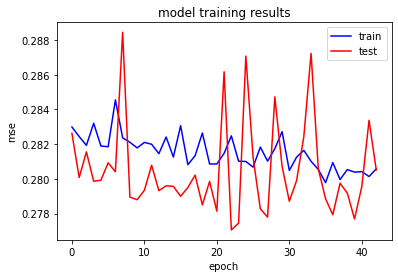

In [20]:
plot_loss(history.history)

In [86]:
autoencoder.load_weights("../savedModels/encoderModel.h5")

### Load in test dataset to see the results 

In [87]:
test = pd.read_csv("../processedData/hold_outset_moreFraud.csv")

In [88]:
test_tf_data, label = test.drop("Class",axis=1).values, test["Class"]

In [89]:
autoencoder.evaluate(test_tf_data,test_tf_data)

1793/1793 [==============================] - 2s 1ms/step - loss: 0.4331


0.43313878774642944

In [90]:
pred_results = autoencoder.predict(test_tf_data)

In [91]:
results = pd.DataFrame({"Class":label,"MSE":np.mean(np.square(test_tf_data-pred_results),axis=1)})

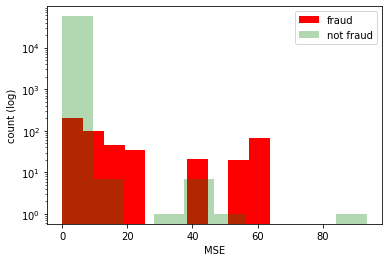

In [92]:
plot_relationship(results, "Class","MSE")

In [93]:
results[results["Class"]==0][["MSE"]].describe()

,MSE
count,56858.000000
mean,0.275824
std,0.723319
min,0.013358
25%,0.131766
50%,0.203169
75%,0.313215
max,93.499242


In [94]:
results[results["Class"]==1][["MSE"]].describe()

,MSE
count,492.000000
mean,17.899928
std,20.675015
min,0.072200
25%,3.673039
50%,8.246633
75%,23.659988
max,63.731148


### cut off for fraud is class = 0 mean + 3std 

In [95]:
results["pred_class"]=results.MSE.apply(lambda x: 1 if x>0.28+3*0.72 else 0)

In [96]:
confusion_matrix(results.Class,results.pred_class)

array([[56727,   131],
       [   93,   399]])

In [97]:
print(classification_report(results.Class, results.pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.75      0.81      0.78       492

    accuracy                           1.00     57350
   macro avg       0.88      0.90      0.89     57350
weighted avg       1.00      1.00      1.00     57350

